The following algorithm can be used to make charts more quickly (e.g., producing outputs for all $T = 10^6$ time steps), under the assumption that the degree bound $D$ is correct.

This algorithm is NOT PRIVATE! It only shows what the added noise would be like. See `full_alg.ipynb` for the private algorithm.

We implement Algorithm 5 from https://arxiv.org/pdf/2403.04630v1.pdf

* Running the code below will generate the "zoomed in" plots (i.e., $50{,}000$ time steps) for $D = 300$ that were presented in the rebuttal.
 * In the code right before "Generate Stream", setting `block = True` and `deg_bd = 15_000` will make the block models described in the rebuttal.
 * Setting `deg_bd = 1_000` will make the plots for $D = 1{,}000$ shown in the rebuttal.
* We use $\varepsilon = 1$, $\delta = 10^{-10}$, $T = 10^6$, $\beta = 0.05$.
 * These values can be changed immediately after the "Run Algorithm" header.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Binary tree mechanism

In [2]:
'''
Modified from code for https://arxiv.org/abs/2306.09666,
in https://github.com/jodander/smooth-binary-mechanism/blob/main/mechanism_noise_generation.py
and https://github.com/jodander/smooth-binary-mechanism/blob/main/example.ipynb
'''

def power_2_iterator(end = None):
    '''Iterate over non-negative powers of 2 in increasing order

    Parameters:
    end: only numbers up to end are output (optional, default is None)

    Returns:
    an iterator object for the sequence
    '''
    x = 1
    while (end is None) or (x <= end):
        yield x
        x *= 2

def binary_mechanism_noise(T, eps = 1., dimensions = 1, noise_generator = np.random.laplace, neutral_element = 0., l1_sens = 1.):
    '''Compute additive noise vector for private counting under continual observation

    This method implements an efficient variant of the classical "Binary Mechanism".

    Adding the noise vector to the prefix sum vector of x in {0,1}^T will make
    it differentially private (specifically, rho-zCDP) with respect to the
    neighboring relation that changes a single bit of x.

    The space usage of the iterator is proportional to log T, it uses constant time
    on average for generating each value. See https://arxiv.org/abs/2306.09666 for details.

    Parameters:
    T: number of time steps
    rho: privacy parameter (optional, default is 1.)
    dimensions: number of noise values output per time step (optional, default is 1)
    noise_generator: generator for Gaussian noise (optional, default is Numpy's)
    neutral_element: zero noise value (optional, default is floating point zero)

    Returns:
    an iterator object for a sequence of T noise vectors
    '''

    # Initialization
    depth = 0
    while 2**depth <= T: # find smallest tree with > T leaves
        depth += 1
    variance = 2 * l1_sens * depth/eps # variance per node to achieve rho-zCDP
    noise = {} # dictionary mapping node depths to noise
    leaves = iter(range(1, T+1))

    # Iteration
    n = neutral_element # Current noise value, always equal to sum of values in noise dict
    l1, l2 = None, 0 # Two adjacent leaves currently considered, paths encoded in binary
    for _ in range(T): # Invariant: 1s in l2 have stored noise, summing to n
        l1, l2 = l2, next(leaves)
        for b in power_2_iterator(l1 ^ l2): # Iterate over bit positions after longest common prefix
            if b & l1 > 0: # Remove nodes from path to previous leaf
                n -= noise[b]
                del noise[b]
            if b & l2 > 0: # Add nodes from path to next leaf
                if b not in noise:
                    noise[b] = noise_generator(0, variance, size=dimensions)
                n += noise[b]
        yield n

# Our Alg

In [3]:
def projection_alg(graph_stream, degree_bound):
  '''
  Implements Alg 1.

  Input: a graph stream (a list of sets of edges), and a degree bound.
  Output: a graph stream with maximum degree degree_bound.
  '''
  degree_counter = {}
  for edges_index_ in graph_stream: # will receive a list of edges at each time step
    edges = graph_stream[edges_index_]
    edges_sorted = edges[np.lexsort([edges[:, 0], edges[:, 1]])] # sort edges in lexicog order
    stream_elt_zeros = np.zeros(np.shape(edges_sorted),dtype = np.int64)
    num_added = 0
    for (node_1, node_2) in edges_sorted: # for (node_1, node_2) in the list of edges
      node_1_deg = degree_counter.get(str(node_1), 0)
      node_2_deg = degree_counter.get(str(node_2), 0)

      add_edge = (node_1_deg < degree_bound) and (node_2_deg < degree_bound)

      if add_edge:
        stream_elt_zeros[num_added] = [node_1, node_2]
        num_added += 1
      # else ignore the edge

      # increase the counter
      degree_counter[str(node_1)] = node_1_deg + 1
      degree_counter[str(node_2)] = node_2_deg + 1
    yield stream_elt_zeros[:num_added,:]

In [4]:
def degree_hist_baseline(graph_stream):
  '''
  Tracks the degree histogram of a graph stream.
  (This can be thought of as a "baseline" for time complexity -- it is a non-optimized
  algorithm for maintaining a degree histogram for a graph.)

  Input: a graph stream.
  Output: the number of edges in the graph stream so far (the degree histogram is maintained but not returned)
  '''
  degree_counter = {}
  num_edges = 0
  for edges_index_ in graph_stream: # will receive a list of edges at each time step
    edges = graph_stream[edges_index_]
    edges_sorted = edges[np.lexsort([edges[:, 0], edges[:, 1]])] # sort edges in lexicog order
    stream_elt_zeros = np.zeros(np.shape(edges_sorted),dtype = np.int64)
    for (node_1, node_2) in edges: # for (node_1, node_2) in the list of edges
      node_1_deg = degree_counter.get(str(node_1), 0)
      node_2_deg = degree_counter.get(str(node_2), 0)

      degree_counter[str(node_1)] = node_1_deg + 1
      degree_counter[str(node_2)] = node_2_deg + 1

      num_edges += 1

    yield num_edges

In [5]:
def sparse_vec(query_stream, threshold, eps):
  '''
  Implements Alg 6. (Note: we hardcode cutoff c = 1.)

  Input: a query stream with sensitivity 1, a threshold, privacy parameter eps.
  Output: False if the (noisy) query is above the threshold, or if a
  previous (noisy) query was above the threshold. Otherwise, output true
  '''
  eps_1 = eps_2 = eps/2
  Z = np.random.laplace(scale = 1/eps_1)
  still_good = True
  for (query, debug) in query_stream:
    Z_t = np.random.laplace(scale = 1/eps_2)
    above_thresh = (query + Z_t >= threshold + Z)
    # print("query", query)
    # print("threshold", threshold)
    if (not above_thresh) and still_good:
      yield True # True is "TOP"
    else:
      still_good = False
      yield False # False is "BOT"

In [6]:
def dtg(D_prime, ell_val, input_stream):
  '''
  Computes DistToGraph_{D_prime, ell_val}(input_stream), as defined in Defn 4.2.
  Note that the algorithm for computing this value follows the method described
  in Lemma 4.3, item 2.

  Input: D_prime, ell_val, graph stream input_stream.
  Output: at each time step, the value of
  DistToGraph_{D_prime, ell_val}(input_stream) -- see Defn 4.2.
  '''
  cum_hist = {}
  curr_deg = {}
  num_nodes = 0
  k_val = max(D_prime + 2, ell_val)

  for new_edges_index_ in input_stream:
    new_edges = input_stream[new_edges_index_]
    for (node_1, node_2) in new_edges:
      # increase node counter if nodes are new
      if not (str(node_1) in curr_deg):
        num_nodes += 1
      if not (str(node_2) not in curr_deg):
        num_nodes += 1

      # update curr_deg
      curr_deg[str(node_1)] = curr_deg.get(str(node_1), 0) + 1
      curr_deg[str(node_2)] = curr_deg.get(str(node_2), 0) + 1

      # update cumulative histogram
      node_1_deg_str = str(curr_deg[str(node_1)])
      node_2_deg_str = str(curr_deg[str(node_2)])
      cum_hist[node_1_deg_str] = cum_hist.get(node_1_deg_str, 0) + 1
      cum_hist[node_2_deg_str] = cum_hist.get(node_2_deg_str, 0) + 1

      # update k
      new_k = k_val
      debug_val = 0
      for k_prime in [k_val, k_val - 1, k_val - 2]:
        cum_hist_lookup = int(D_prime - k_prime + 1)
        if k_prime >= max(D_prime - num_nodes + 2, 0):
          debug_val = [str(cum_hist_lookup), cum_hist.get(str(cum_hist_lookup), 0)]
          if k_prime + cum_hist.get(str(cum_hist_lookup), 0) >= ell_val:
            new_k = k_prime

      k_val = new_k
    # once we've looked at all edges in the stream elt, release k_val
    # actually, release -1 * k_val.
    yield (-1 * k_val, [num_nodes, D_prime + 2, ell_val, max(D_prime - num_nodes + 2, 0), debug_val])

In [7]:
def blackbox_priv(deg_bd, beta, beta_test, time_steps, eps_test, eps, delta, input_stream, private_only = True):
  '''
  Implements Alg 5.

  Input: the values provided to Alg 5 -- with the exception of RestrictedPrivAlg -- plus values eps and delta.
  Output: an (eps, delta)-node-DP edge count.

  NOTE: We hardcode an eps_prime-edge-DP edge-counting function as RestrictedPrivAlg.
  '''
  D_val = deg_bd
  tau = -8 * np.log(1 / beta_test) / eps_test
  ell_val = np.ceil(8 * np.log(time_steps / (beta * beta_test)) / eps_test)
  D_prime = D_val + ell_val

  eps_prime = (eps - eps_test)/(D_prime + ell_val)
  del_prime = (delta - (1 + np.exp(eps_test)) * np.exp(eps) * beta_test) / (np.exp(eps_prime*(D_prime + ell_val)) * (D_prime + ell_val))

  # generate binary tree noise
  binary_mechanism_noise_vector = np.fromiter(binary_mechanism_noise(time_steps, eps_prime, dimensions=1, l1_sens=1), float)
  advanced_comp_noise = np.random.normal(scale = (D_val * np.sqrt(time_steps) / eps) * np.sqrt(2 * np.log(1.25/delta)), size = time_steps)

  return (0, binary_mechanism_noise_vector, advanced_comp_noise)

# Generate Graph

In [8]:
def make_graph(num_nodes, num_edges, block = False, num_high_deg = 0, average_high_deg = 0):
  '''
  Make a graph with num_nodes nodes, num_edges edges ().
  If block = true, then make num_high_deg of these nodes have high degree,
  where these high-degree nodes have an average of average_high_deg additional edges
  (centered at average_high_deg, drawn uniformly from [average_high_deg/2, average_high_deg*1.5])

  Input: see description above.
  Output: an edge list for a graph with the specified properties.
  '''

  # generate 1d array of coords
  edge_list_flat = np.random.randint(0, int(num_nodes), size=2*int(num_edges))
  edge_list_2d = edge_list_flat.reshape(-1,2)

  # sort array so smallest coord is first
  smallest_first = np.sort(edge_list_2d, axis=1)

  # if block model, make some of the nodes have high degree.
  if block:
    # which nodes have high degree
    high_deg_nodes = np.random.choice(int(num_nodes), int(num_high_deg), replace=False)

    # degree val for the high degree nodes
    high_deg_vals = np.random.randint(int(average_high_deg/2), int(average_high_deg * 1.5), size= num_high_deg)

    num_edges = np.sum(high_deg_vals)

    to_add = np.zeros((num_edges,2), dtype = np.int64)

    start_index = 0
    end_index = 0

    for index_val in range(num_high_deg):
      deg_of_node = high_deg_vals[index_val]
      first_coord = np.repeat(int(high_deg_nodes[index_val]), deg_of_node)
      second_coord = np.random.randint(0, int(num_nodes), size=deg_of_node)

      result = np.dstack((first_coord,second_coord))

      # sort so first coord smaller
      result = np.sort(result, axis=1)

      end_index += deg_of_node

      to_add[start_index:end_index,:] = result

      start_index = end_index

    # if block model, combine the lists
    combined_lists = np.vstack((smallest_first, to_add))

  # otherwise, don't combine the lists.
  else:
    combined_lists = smallest_first

  return combined_lists


In [9]:
# Create a graph with the following properties
num_nodes = 1e6
num_edges = 2e8

num_high_deg = 5_000
average_high_deg = 10_000

# set to True if we want a block model
block = True

combined_lists = make_graph(num_nodes, num_edges, block, num_high_deg, average_high_deg)

# Generate Stream

In [10]:
def graph_to_graph_stream(orig_graph, time_steps):
  '''
  Convert orig_graph to a graph stream, with its edges distributed
  uniformly over all time_steps time steps.

  Input: a graph orig_graph, an integer time_steps for the number of
  time steps over which the graph should arrive.
  Output: a graph stream (i.e., a list of sets of edges)
  '''

  edge_count = np.shape(orig_graph)[0]

  timed_edges = orig_graph

  rng = np.random.default_rng()
  # rng.shuffle(timed_edges)

  # randomly divide up the edges in the graph
  goal_time_steps = int(time_steps) # number of times steps by which all edges should arrive
  mean_edges_per_time_step = int(edge_count/goal_time_steps)
  num_edges_per_time = rng.integers(low = 0, high = 2*mean_edges_per_time_step, size = time_steps) # randomly look at the next 'num_edges_per_time[t]' edges at time t

  cumulative_edges_per_time = np.cumsum(num_edges_per_time)

  start_edge = 0
  for time_step in range(time_steps):
    end_edge = min(cumulative_edges_per_time[time_step], edge_count) # don't want to overflow
    edge_set = timed_edges[start_edge:end_edge, :]
    start_edge = end_edge

    yield edge_set

In [ ]:
# generate the graph stream
time_steps = int(1e6)

# store the graph stream from combined_lists in graph_stream
graph_stream = {}

index = 0
for item in graph_to_graph_stream(combined_lists, time_steps):
  graph_stream[str(index)] = item
  index += 1
  if index % 100 == 0:
    print(index)

# Run Algorithm

In [12]:
# Run algorithm with the following parameters
fail_prob = 0.05
eps = 1
eps_test = eps/2
delta = 1/1e10
fail_prob_test = delta/30
deg_bd = 15_000

# generate noise
(true_noise, noise_bin_tree, noise_advanced_comp) = blackbox_priv(deg_bd, fail_prob, fail_prob_test, time_steps, eps_test, eps, delta, graph_stream, private_only = False)

# count number of elts in stream
stream_elt_count = np.zeros(time_steps, dtype = np.int64)
index = 0
for stream_elt_key_ in graph_stream:
  stream_elt_count[index] = np.shape(graph_stream[stream_elt_key_])[0]
  index += 1

# store true answers in true_ans, our alg's answers in noisy_ans,
# and batch model alg with gaussian noise in noisy_basic.
true_ans = np.cumsum(stream_elt_count)
noisy_ans = true_ans + noise_bin_tree
noisy_basic = true_ans + noise_advanced_comp

<ipython-input-7-a12be67ed9c1>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_mechanism_noise_vector = np.fromiter(binary_mechanism_noise(time_steps, eps_prime, dimensions=1, l1_sens=1), float)


# Create Plots

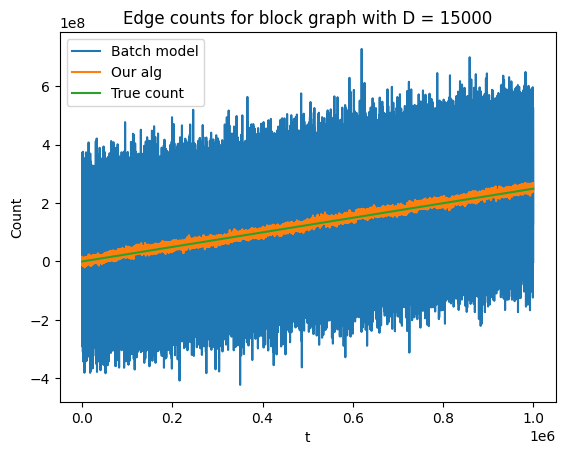

In [15]:
stop_after = int(10**6)

# Plot edge counts from naive batch, our alg, and the true count
t = np.arange(0, time_steps)

x_axis = int(stop_after)

plt.figure()
plt.plot(t[:x_axis], noisy_basic[:x_axis], label='Batch model')
plt.plot(t[:x_axis], noisy_ans[:x_axis], label='Our alg')
plt.plot(t[:x_axis], true_ans[:x_axis], label='True count')
plt.xlabel("t")
plt.ylabel("Count")
plt.title(f'Edge counts for block graph with D = {deg_bd}')
plt.legend()
plt.show()

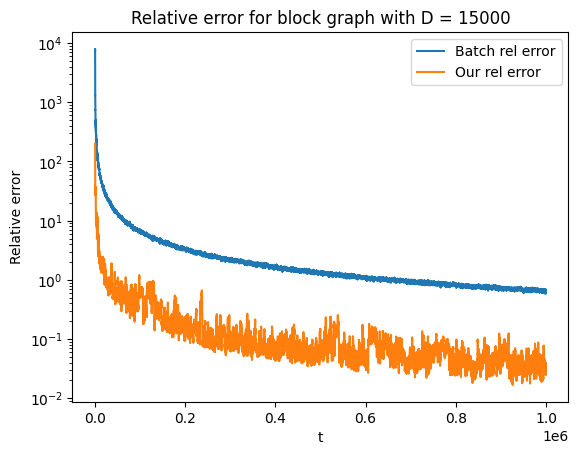

In [16]:
# plot rel error
x_start = 0 # time at which the x-axis should start
x_end = int(stop_after) - 200
plot_start = 10_000

naive_error = np.abs(noisy_basic - true_ans)

our_error = np.abs(noisy_ans - true_ans)


plt.figure()

# smooth
smooth_steps = 500
plt.semilogy(t[x_start:x_end], (np.convolve((naive_error / (true_ans/2))[x_start:], np.ones(smooth_steps), mode = 'same')/smooth_steps)[x_start:x_end], label='Batch rel error')
plt.semilogy(t[x_start:x_end], (np.convolve((our_error / (true_ans/2))[x_start:], np.ones(smooth_steps), mode = 'same')/smooth_steps)[x_start:x_end], label='Our rel error')

plt.xlabel("t")
plt.ylabel("Relative error")
plt.legend()
plt.title(f'Relative error for block graph with D = {deg_bd}')
plt.show()